NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro)

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sourceCode .sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

前面数值为概率的log,可以用exp还原为原始概率
```
import numpy as np
np.exp([-0.47, -1.52, -3.57]).round(2) 
>> array([0.63, 0.22, 0.03])
```

Preparing the Data
------------------

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>
</div>

Included in the `names` directory are 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [49]:
from io import open
import glob
import os

def findFiles(path): 
    return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [50]:
category_lines

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [48]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [51]:
n_letters

57

In [52]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor #ohe

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

This RNN module implements a \"vanilla RNN\" and is just 3 linear layers
which operate on an input and hidden state, with a `LogSoftmax` layer
after the output.


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn = RNN(n_letters, n_hidden, n_categories).to(device)

### Log Softmax

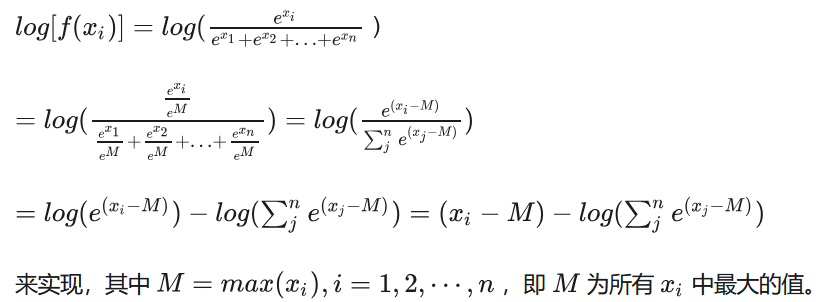

torch.logsumexp()也是类似的trick,避免运算溢出


(dot.exe:20220): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


model is on: cuda:0


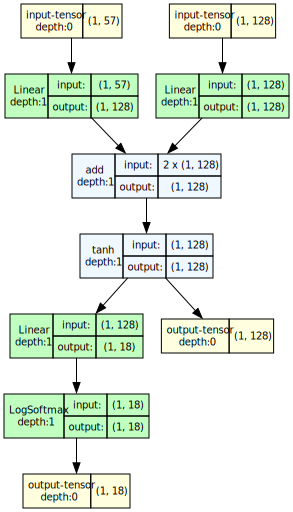

In [54]:
from torchview import draw_graph

print('model is on:', next(rnn.parameters()).device)

model_graph = draw_graph(rnn, input_size=(torch.Size([1, 57]), torch.Size([1, 128])), expand_nested=True) # RNN has two inputs
model_graph.visual_graph

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [55]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
print (input.shape, hidden.shape)

output, next_hidden = rnn(input.to(device), hidden.to(device))

torch.Size([1, 57]) torch.Size([1, 128])


For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0].to(device), hidden.to(device))
print(output)

tensor([[-2.8749, -2.8990, -3.0044, -3.0013, -2.8456, -2.8940, -2.8526, -2.7400,
         -2.9898, -2.7624, -2.9068, -2.9673, -2.9114, -2.9539, -2.8535, -2.8539,
         -2.8948, -2.8673]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 7)


We will also want a quick way to get a training example (a name and its
language):


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Pantelas
category = Dutch / line = Niftrik
category = Irish / line = Bradan
category = Polish / line = Szwedko
category = Italian / line = Padovan
category = Chinese / line = Chu
category = Japanese / line = Ichiro
category = English / line = Mccann
category = Chinese / line = Dong
category = Japanese / line = Takara


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.

NLLLoss (negative log likelihood loss) + LogSoftmax = CrossEntropy

In [56]:
from torch.nn.functional import nll_loss, cross_entropy, log_softmax

p = torch.tensor([.2, .3, .5]) # predict
t = torch.tensor([0., 0., 1.]) # truth

print('cross_entropy: ', cross_entropy(p,t))
print('log_softmax: ', log_softmax(p, dim=0), ', nll_loss + log_softmax: ', nll_loss(log_softmax(p, dim=0), t.argmax()))

cross_entropy:  tensor(0.9398)
log_softmax:  tensor([-1.2398, -1.1398, -0.9398]) , nll_loss + log_softmax:  tensor(0.9398)


In [12]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [17]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden().to(device)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) # forward

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate) # GD

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 32s) 0.2335 Faucher / French ✓
10000 10% (1m 8s) 0.7228 Yun / Korean ✗ (Chinese)
15000 15% (1m 42s) 0.1059 Tankoshitsu / Japanese ✓
20000 20% (2m 14s) 0.0150 Cleirich / Irish ✓
25000 25% (2m 43s) 0.0048 Mimasuya / Japanese ✓
30000 30% (3m 10s) 0.0625 Thian / Chinese ✓
35000 35% (3m 41s) 0.1133 Shang / Chinese ✓
40000 40% (4m 9s) 0.2739 Achteren / Dutch ✓
45000 45% (4m 38s) 0.1185 Starek / Polish ✓
50000 50% (5m 9s) 1.5046 Molloy / Scottish ✗ (Irish)
55000 55% (5m 37s) 1.6096 Oberst / French ✗ (German)
60000 60% (6m 6s) 3.2920 Alexander / French ✗ (Scottish)
65000 65% (6m 39s) 0.1933 Chin / Korean ✓
70000 70% (7m 11s) 1.7343 Olguin / Irish ✗ (Spanish)
75000 75% (8m 21s) 0.7472 Bonner / French ✓
80000 80% (10m 27s) 1.4114 Switzer / Dutch ✗ (German)
85000 85% (12m 26s) 0.0923 Tieu / Vietnamese ✓
90000 90% (12m 57s) 0.5106 Uoya / Japanese ✓
95000 95% (13m 30s) 3.2128 Wang / Chinese ✗ (Korean)
100000 100% (14m 0s) 5.8592 Rivkind / English ✗ (Russian)


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


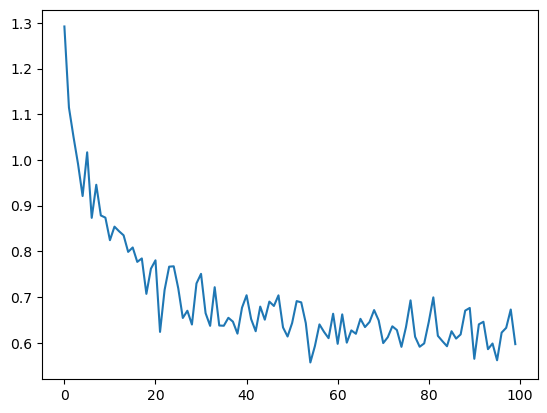

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Save & Load Weights
===================


In [20]:
torch.save(rnn, 'rnn.pt')

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn = torch.load('rnn.pt').to(device)
print('model is on:', next(rnn.parameters()).device)

model is on: cuda:0


C:\Users\eleve\AppData\Local\Temp\ipykernel_21548\806783056.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn = torch.load('rnn.pt').to(device)


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


C:\Users\eleve\AppData\Local\Temp\ipykernel_21548\4090311015.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\eleve\AppData\Local\Temp\ipykernel_21548\4090311015.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


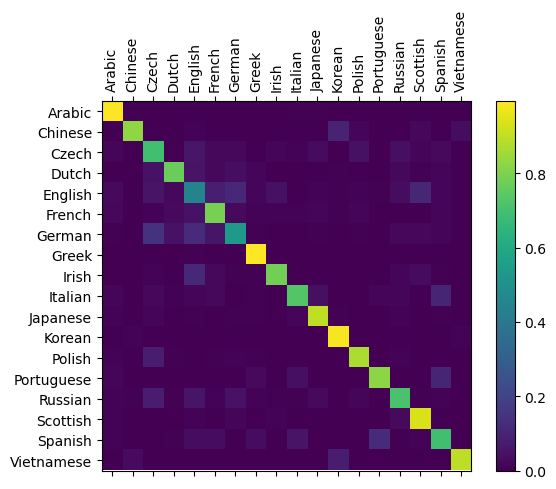

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to(device)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [44]:
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():

        input = lineToTensor(input_line).to(device)
        output = evaluate(input)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict('Kolmogorov')
predict('Kim')
predict('Satoshi')
predict('Zhang')


> Kolmogorov
(0.98) Russian
(0.01) Czech
(0.01) Italian

> Kim
(0.81) Korean
(0.14) Vietnamese
(0.04) Chinese

> Satoshi
(0.98) Japanese
(0.01) Italian
(0.00) Russian

> Zhang
(0.98) Chinese
(0.02) Korean
(0.00) Vietnamese


### 虽然做了支持cuda的改造,但经典RNN无法并行化, 使得GPU+CUDA的优势无法发挥

Exercises
=========

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
-   Get better results with a bigger and/or better shaped network
    -   Add more linear layers
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network
